In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load data
ff = pd.read_csv('data/2017/freeformResponses.csv')
mc = pd.read_csv('data/2017/multipleChoiceResponses.csv', encoding="ISO-8859-1")

In [3]:
df = mc.loc[:, ['GenderSelect', 'Age', 'CompensationAmount', 'CompensationCurrency']]

In [4]:
df_no_null = df.dropna(axis=0, how='any')
df_no_null['CompensationAmountStrings'] = df_no_null.CompensationAmount.str.replace(r'\d', '').str.replace(r',', '')

# Remove points w/ negatives
df_no_null = df_no_null[df_no_null.CompensationAmountStrings != '-']

# Remove ".", ",", and ".E+" from CompensationAmount
df_no_null.CompensationAmount = df_no_null.CompensationAmount.str.replace(',', '')

# Turn CompensationAmount to Float
df_no_null.CompensationAmount = pd.to_numeric(df_no_null.CompensationAmount)

# Multiply all w/ ".E+" by 100000000000
# df_no_null.loc[df_no_null.CompensationAmountStrings == '.E+', 'CompensationAmount'] *= 100000000000

# Divide all w/ "." by 100
# df_no_null.loc[df_no_null.CompensationAmountStrings == '.', 'CompensationAmount'] /= 100000000000


df_no_null.CompensationAmountStrings.value_counts()

       4336
.         6
.E+       2
Name: CompensationAmountStrings, dtype: int64

In [18]:
# Convert compensation to USD
cr = pd.read_csv('data/2017/conversionRates.csv', index_col=0)

df_USD = pd.merge(df_no_null, cr, left_on = 'CompensationCurrency', right_on = 'originCountry', how='left')
df_USD['Compensation'] = df_USD.CompensationAmount * df_USD.exchangeRate

# Compensation Outliers
lower_C, upper_C = df_USD.Compensation.quantile([0.25, 0.75])
IQ = (upper_C - lower_C) * 1.5

# Age Outliers
lower_A, upper_A = df_USD.Age.quantile([0.25, 0.75])
IQ = (upper_A - lower_A) * 1.5
# df_clean = df_USD.loc[(df_USD.Age >= lower_A - IQ) & (df_USD.Age <= upper_A + IQ) & (df_USD.Compensation >= lower_C - IQ) & (df_USD.Compensation <= upper_C + IQ)]
df_clean = df_USD.loc[(df_USD.Age <= upper_A + IQ) & (df_USD.Compensation <= upper_C + IQ)]


In [19]:
df_final = df_clean.drop(['CompensationAmount', 'CompensationCurrency', 'CompensationAmountStrings', 'originCountry', 'exchangeRate'], axis=1)

# df_final.groupby('GenderSelect').describe().T
df_final['Gender'] = df_final.GenderSelect.apply(lambda x: 1 if x != 'Male' else 0)
df_final.drop('GenderSelect', axis=1)

,Age,Compensation,Gender
1,43.0,64184.80,1
2,33.0,20882.40,0
3,27.0,1483.90,0
4,26.0,36634.40,0
5,25.0,20000.00,0
...,...,...,...
4337,39.0,1.00,0
4338,38.0,65770.43,0
4339,56.0,50000.00,0
4342,32.0,89686.95,0


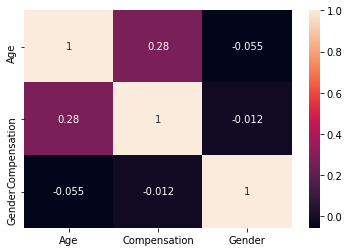

In [20]:
# df_final.groupby('Gender').describe().T
# sns.pairplot(df_final)
sns.heatmap(df_final.corr(), annot=True)

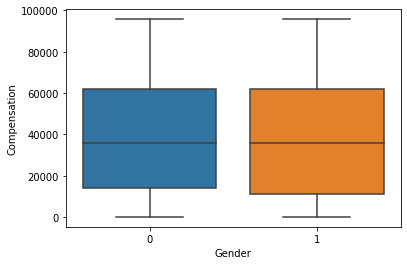

In [21]:
sns.boxplot(
    x='Gender',
    y='Compensation',
    data=df_final
)

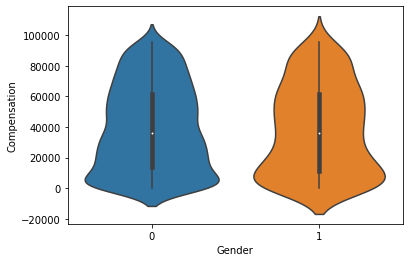

In [25]:
sns.violinplot(
    x='Gender',
    y='Compensation',
    data=df_final
)

In [27]:
male = df_final.loc[df_final.Gender == 0]
m_mean = male.Compensation.mean()
female = df_final.loc[df_final.Gender == 1]
f_mean = female.Compensation.mean()
print('Male: ${:,.2f}'.format(m_mean))
print('Female: ${:,.2f}'.format(f_mean))

Male: $39,192.71
Female: $38,236.68


In [28]:
m_n = male.Compensation.count()
f_n = female.Compensation.count()
print('Male: {:,}'.format(m_n))
print('Female: {:,}'.format(f_n))

Male: 2,724
Female: 489


In [32]:
from scipy.stats import ttest_ind

ttest_ind(
    male.Compensation,
    female.Compensation,
)

Ttest_indResult(statistic=0.6860200464975488, pvalue=0.4927499960904598)

In [31]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(
    male.Compensation,
    female.Compensation,
)

(0.6860200464975488, 0.4927499960904598, 3211.0)

In [33]:
m_se = ((male.Compensation - m_mean)**2).sum() / (m_n - 1)
f_se = ((female.Compensation - f_mean)**2).sum() / (f_n - 1)

tt = (m_mean - f_mean) / np.sqrt((m_se / m_n) + (f_se / f_n))

print(tt)

from scipy.stats import t

t.sf(np.abs(tt), m_n - 1) * 2

0.6729138448648561


0.5010592048529054

In [34]:
def my_ttest(a, b, c):
    s_sq = (((a[c] - a[c].mean())**2).sum() + ((b[c] - b[c].mean())**2).sum()) / (len(a[c]) + len(b[c]) - 2)
    t = (a[c].mean() - b[c].mean()) / np.sqrt((s_sq / len(a[c])) + (s_sq / len(b[c])))
    return s_sq, t


my_ttest(male, female, 'Compensation')

(805155790.1463596, 0.6860200464975957)

In [10]:
df_occ = pd.read_csv('data/inc_occ/inc_occ_gender.csv')
df_occ.head()

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na


In [32]:
df_occ.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [36]:
df_occ_full = df_occ.loc[(df_occ.All_weekly != 'Na') & (df_occ.M_weekly != 'Na') & (df_occ.F_weekly != 'Na')].copy()

In [50]:
df_occ_full['All_weekly'] = pd.to_numeric(df_occ_full.All_weekly)
df_occ_full['M_weekly'] = pd.to_numeric(df_occ_full.M_weekly)
df_occ_full['F_weekly'] = pd.to_numeric(df_occ_full.F_weekly)

In [51]:
df_occ_full['F/M Weekly Ratio'] = df_occ_full.F_weekly / df_occ_full.M_weekly
df_occ_full['F/M Weekly Difference'] = df_occ_full.F_weekly - df_occ_full.M_weekly

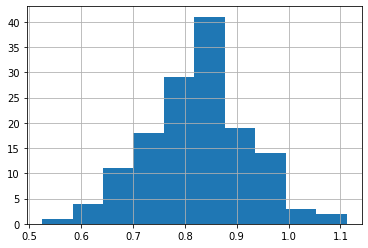

In [52]:
df_occ_full['F/M Weekly Ratio'].sort_values(ascending=False).hist()

In [53]:
df_occ_full['F/M Weekly Difference'].sort_values(ascending=False)

35      99
340     49
345     13
228      8
304      2
      ... 
110   -600
10    -602
287   -694
54    -705
133   -742
Name: F/M Weekly Difference, Length: 142, dtype: int64

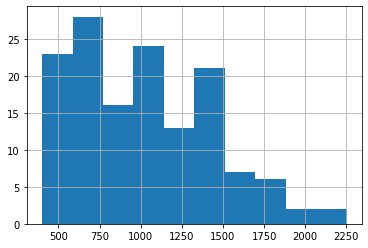

In [56]:
df_occ_full['M_weekly'].hist()

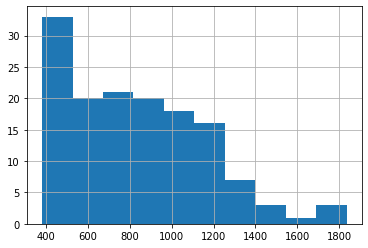

In [58]:
df_occ_full['F_weekly'].hist()

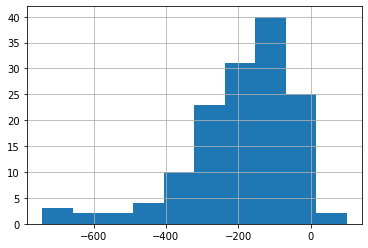

In [54]:
df_occ_full['F/M Weekly Difference'].hist()

In [55]:
from scipy.stats import ttest_ind

ttest_ind(
    df_occ_full['M_weekly'],
    df_occ_full['F_weekly']
)

Ttest_indResult(statistic=4.326206192182078, pvalue=2.1079045880561343e-05)